In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.datasets import make_classification
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score
from scipy.spatial import Voronoi, voronoi_plot_2d
from matplotlib.patches import Patch
from matplotlib import cm
%matplotlib inline

### Clustering evaluation function

In [2]:
def evaluate_clustering(X, labels, n_clusters, ax=None, title_suffix=""):
    if ax is None:
        ax = plt.gca()  # Get the current axis if none is provided

    # Calculate silhouette scores
    silhouette_avg = silhouette_score(X, labels)
    sample_silhouette_values = silhouette_samples(X, labels)

    # Plot silhouette analysis on the provided axis
    unique_labels = np.unique(labels)
    colors = cm.tab10(np.linspace(0, 1, n_clusters))

    y_lower = 10
    for i , label in enumerate(unique_labels):
        cluster_silhouette_vals = sample_silhouette_values[labels == label]
        cluster_silhouette_vals.sort()
        size = len(cluster_silhouette_vals)
        y_upper = y_lower + size

        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
        ax.text(-0.05, y_lower + size/2, str(label))
        y_lower = y_upper + 10
        ax.set_title(f'Silhouette Score for {title_suffix} \n' + 
                     f'Average Silhouette: {silhouette_avg:.2f}')
        ax.set_xlabel('Silhouette Coefficient')
        ax.set_ylabel('Cluster')
        ax.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax.set_xlim([-0.25, 1])
        ax.set_yticks([])

### Create synthetic data with four blobs to experiment with k-means clustering

Here we'll make some synthetic data consisting of slightly overlapping blobs, then run and evaluate k-means with k=4 clusters.

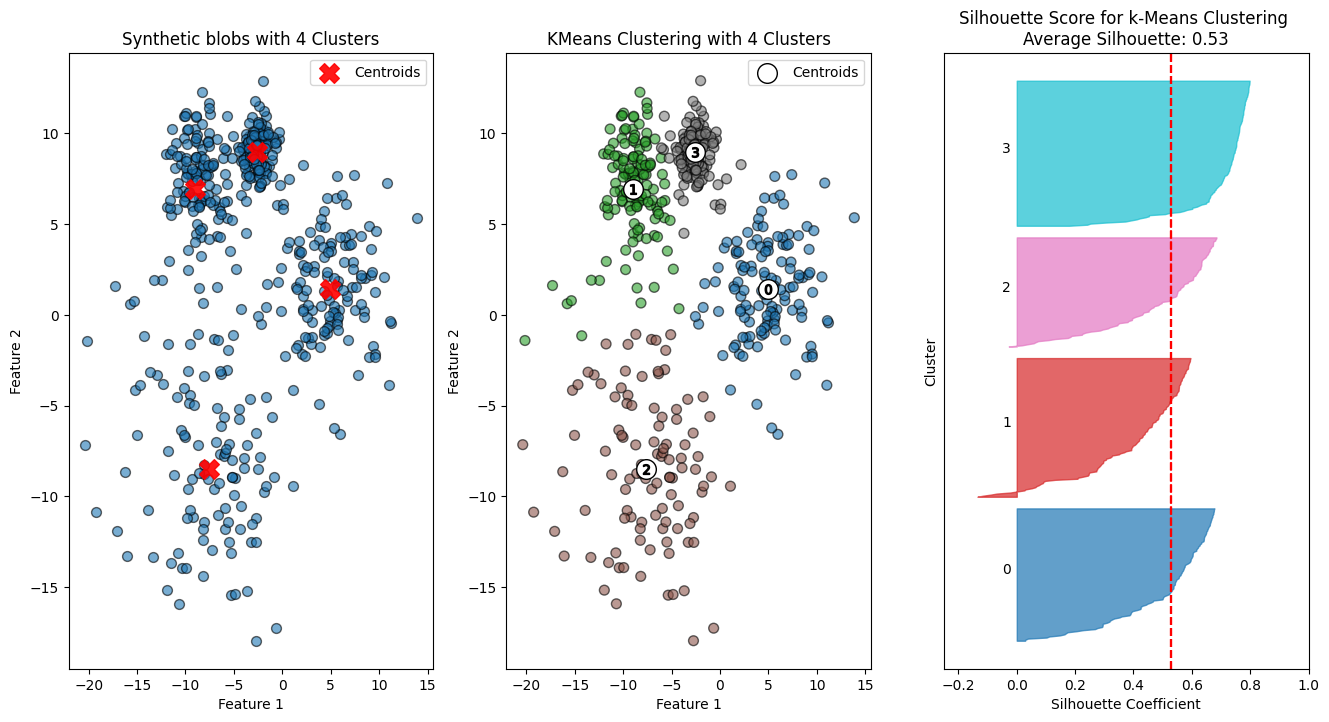

In [3]:
X, y = make_blobs(n_samples=500, n_features=2, centers=4, cluster_std=[1.0, 3, 5, 2], random_state=42)  # or cluster_std=np.random.uniform(0.5, 5.0, size=centers)

# Apply KMeans clustering
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
y_kmeans = kmeans.fit_predict(X)

colormap = cm.tab10

# Plot the blobs
plt.figure(figsize=(16, 8))
plt.subplot(1, 3, 1)
plt.scatter(X[:, 0], X[:, 1], s=50, alpha=0.6, edgecolor="k")
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c="red", s=200, marker="X", alpha=0.9, label="Centroids")
plt.title(f"Synthetic blobs with {n_clusters} Clusters")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

# Plot the clustering result
# Create colors based on the predicted labels
colors = colormap(y_kmeans.astype(float) / n_clusters)

plt.subplot(1, 3, 2)
plt.scatter(X[:, 0], X[:, 1], c=colors, s=50, alpha=0.6, edgecolor="k")

# Label the clusters
centers = kmeans.cluster_centers_

# Draw white circles at cluster centers
plt.scatter(centers[:, 0], centers[:, 1], marker="o", c="white", alpha=1, s=200, edgecolor="k", label="Centroids")

# Label the custer number
for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

plt.title(f'KMeans Clustering with {n_clusters} Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

# Evaluate the clustering
plt.subplot(1, 3, 3)
evaluate_clustering(X, y_kmeans, n_clusters, title_suffix="k-Means Clustering")
plt.show()

### Cluster Stability

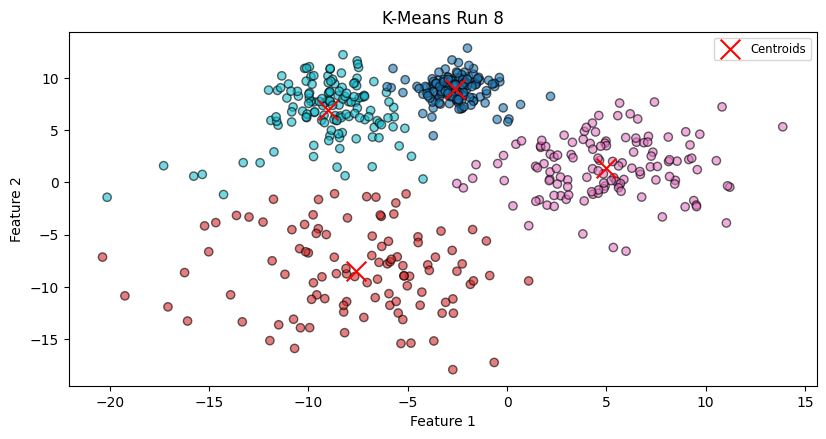

Run 1: Inertia=7633.51
Run 2: Inertia=8556.67
Run 3: Inertia=7633.51
Run 4: Inertia=7633.51
Run 5: Inertia=9626.09
Run 6: Inertia=7633.51
Run 7: Inertia=8556.67
Run 8: Inertia=7633.51


In [4]:
# Number of runs for k-means with different random states
n_runs = 8
inertia_values = []

# Calculate number of rows and columns needed for subplots
n_cols = 2
n_rows = -(-n_runs // n_cols)  # Ceil division to determine rows
plt.figure(figsize=(16, 16))

# Run K-Means multiple times with different random states
for i in range(n_runs):
    kmeans = KMeans(n_clusters=4, random_state=None)
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)

# Plot the clustering result
plt.subplot(n_rows, n_cols, i+1)
plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap="tab10", alpha=0.6, edgecolor="k")
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c="red", s=200, marker="x", label="Centroids")
plt.title(f"K-Means Run {i+1}")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc="upper right", fontsize="small")
plt.tight_layout()
plt.show()

# Print inertia values
for i, inertia in enumerate(inertia_values, start=1):
    print(f"Run {i}: Inertia={inertia:.2f}")

### Number of clusters

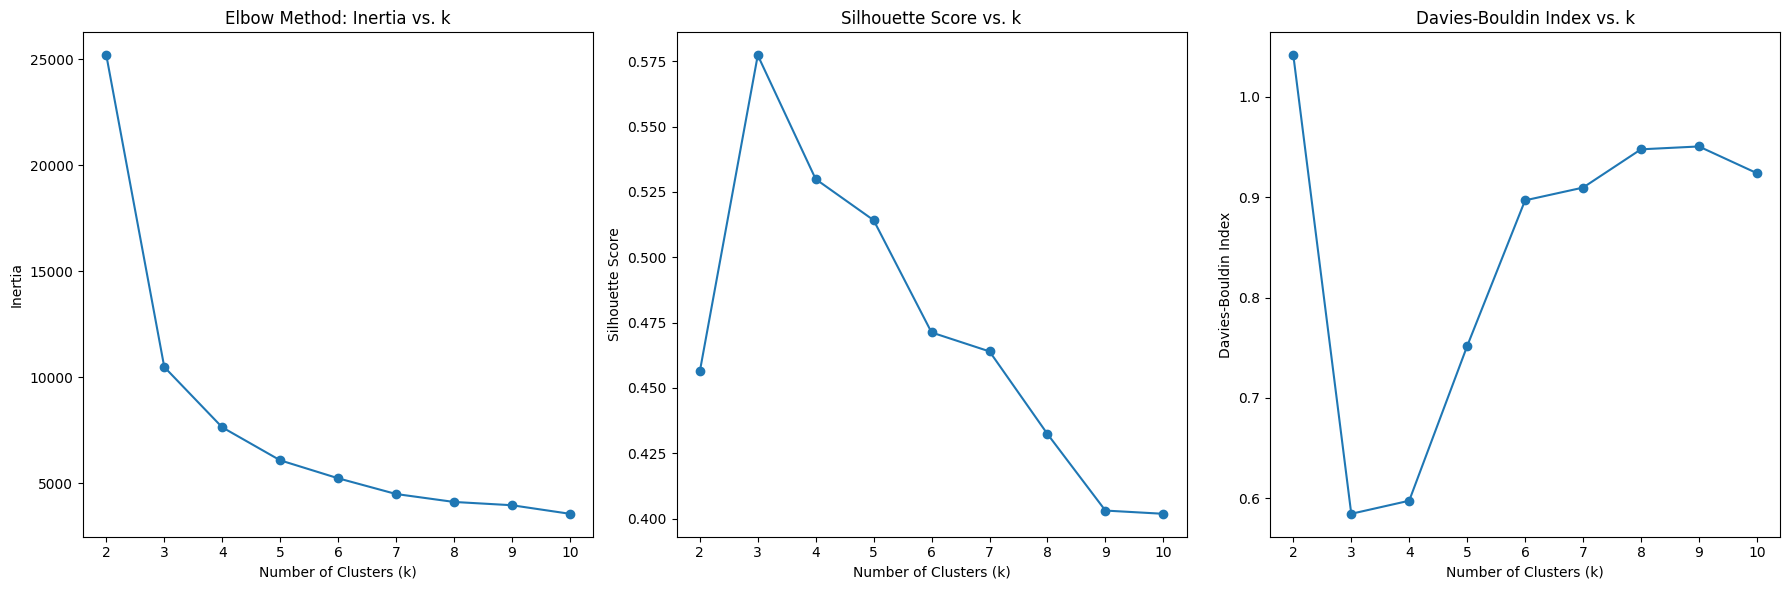

In [5]:
# Range of k values to test
k_values = range(2, 11)

# Store performance metrics
inertia_values = []
silhouette_scores = []
davies_bouldin_indices = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    y_kmeans = kmeans.fit_predict(X)

    # Calculate and store metrics
    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, y_kmeans))
    davies_bouldin_indices.append(davies_bouldin_score(X, y_kmeans))

# Plot the inertia values (Elbow Method)
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(k_values, inertia_values, marker="o")
plt.title('Elbow Method: Inertia vs. k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')

# Plot silhouette scores
plt.subplot(1, 3, 2)
plt.plot(k_values, silhouette_scores, marker="o")
plt.title('Silhouette Score vs. k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')

# Plot Davies-Bouldin Index
plt.subplot(1, 3, 3)
plt.plot(k_values, davies_bouldin_indices, marker="o")
plt.title('Davies-Bouldin Index vs. k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')

plt.tight_layout()
plt.show()

### Plot the blobs and the clustering results for k = 3, 4, and 5

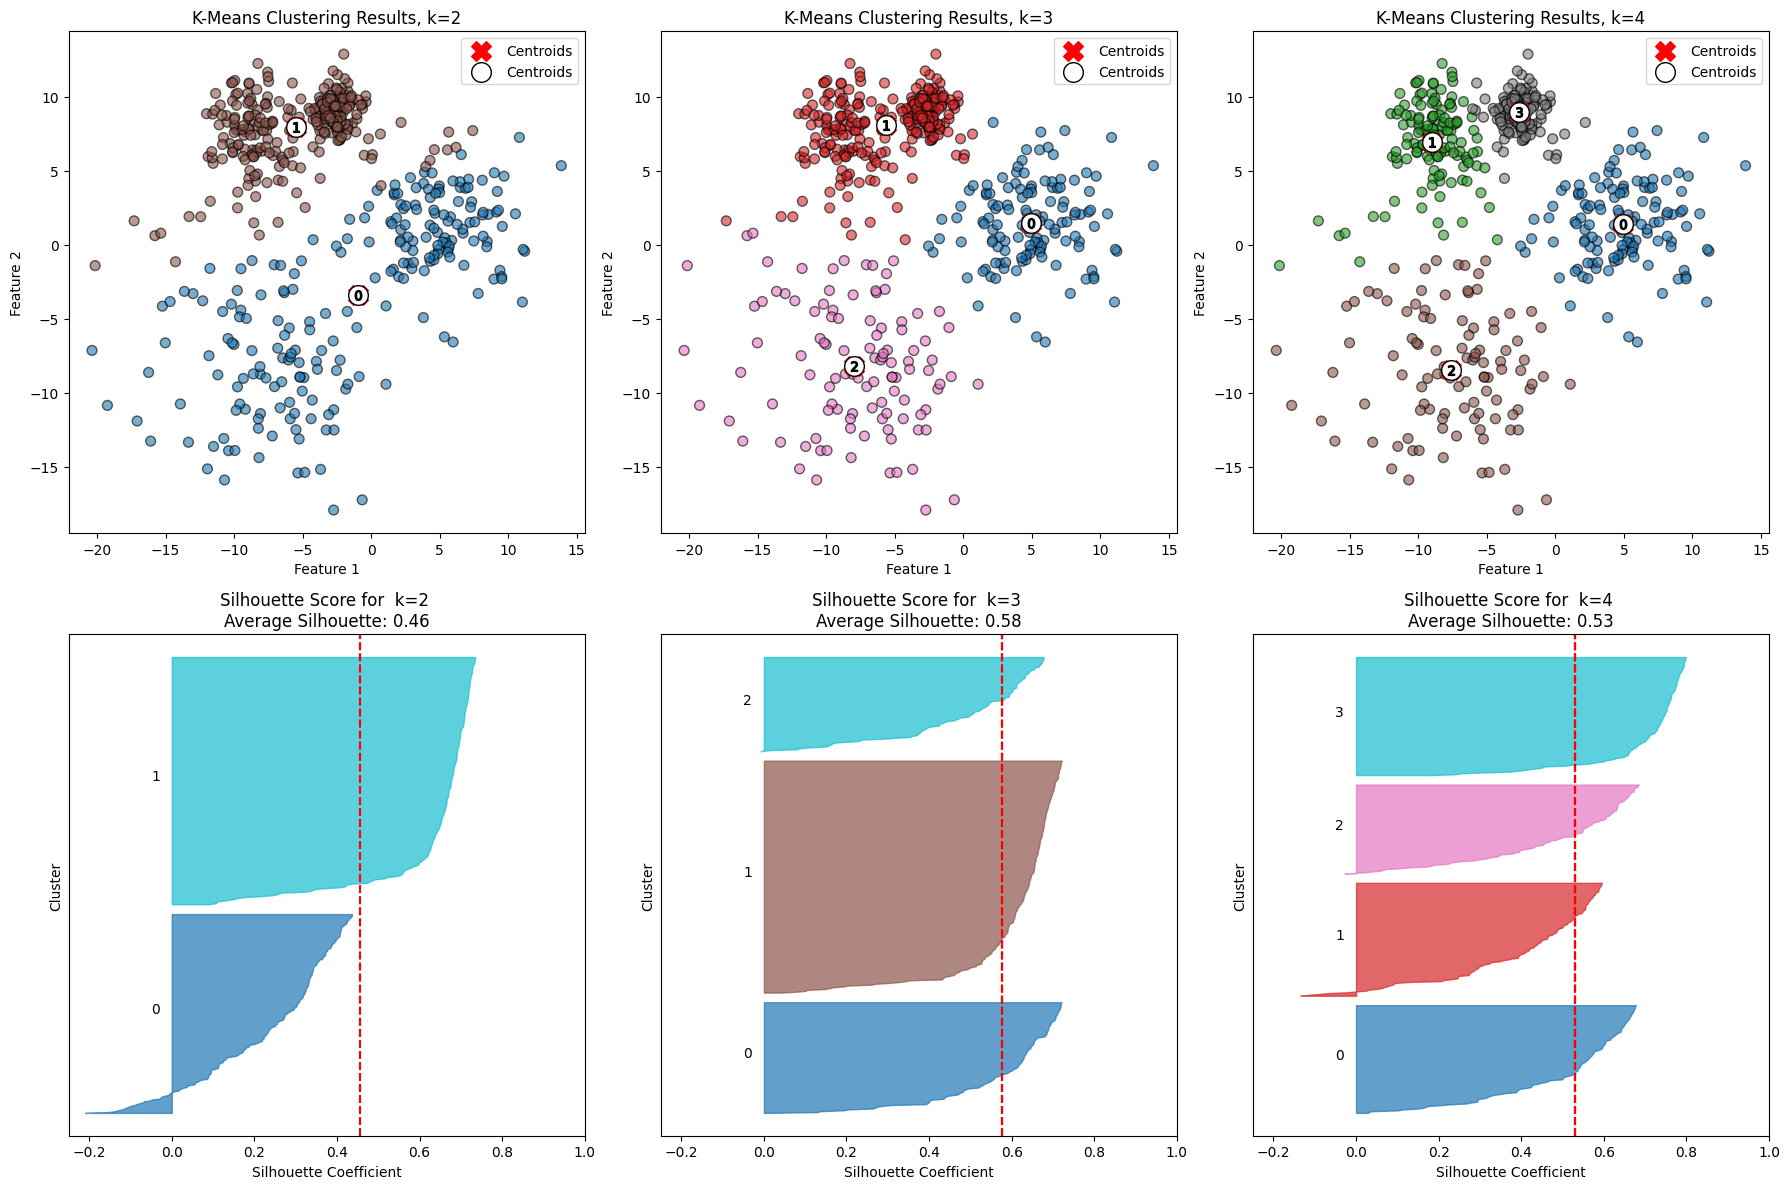

In [7]:
plt.figure(figsize=(18, 12))
colormap = cm.tab10

for i, k in enumerate([2, 3, 4]):
    # Fit KMeans and predict labels
    kmeans = KMeans(n_clusters=k, random_state=42)
    y_kmeans = kmeans.fit_predict(X)

    # Create colors based on the predicted labels
    colors = colormap(y_kmeans.astype(float)/k)

    # Scatter plot for each k in the first row (1, 2, 3)
    ax1 = plt.subplot(2, 3, i+1)
    ax1.scatter(X[:, 0], X[:, 1], c=colors, s=50, alpha=0.6, edgecolor="k")
    ax1.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c="red", s=200, marker="X", label="Centroids")

    # Labeling the clusters
    centers = kmeans.cluster_centers_

    # Draw white circles at cluster centers
    plt.scatter(centers[:, 0], centers[:, 1], marker="o", c="white", alpha=1, s=200, edgecolor="k", label="Centroids")

    for i_, c in enumerate(centers):
        plt.scatter(c[0], c[1], marker="$%d$" % i_, alpha=1, s=50, edgecolor="k")

    ax1.set_title(f'K-Means Clustering Results, k={k}')
    ax1.set_xlabel('Feature 1')
    ax1.set_ylabel('Feature 2')
    ax1.legend()

    # Silhouette plot for each k in the second row (4, 5, 6)
    ax2 = plt.subplot(2, 3, i + 4)
    evaluate_clustering(X, y_kmeans, k, ax=ax2, title_suffix=f" k={k}")

plt.tight_layout()
plt.show()

### Limitations of k-means - Shape sensitivity

Using make_classification we'll create a labelled, 2-d dataset cosisting of three classes. This time we'll have differently shaped sets of points in each class, not just spherical blobs.

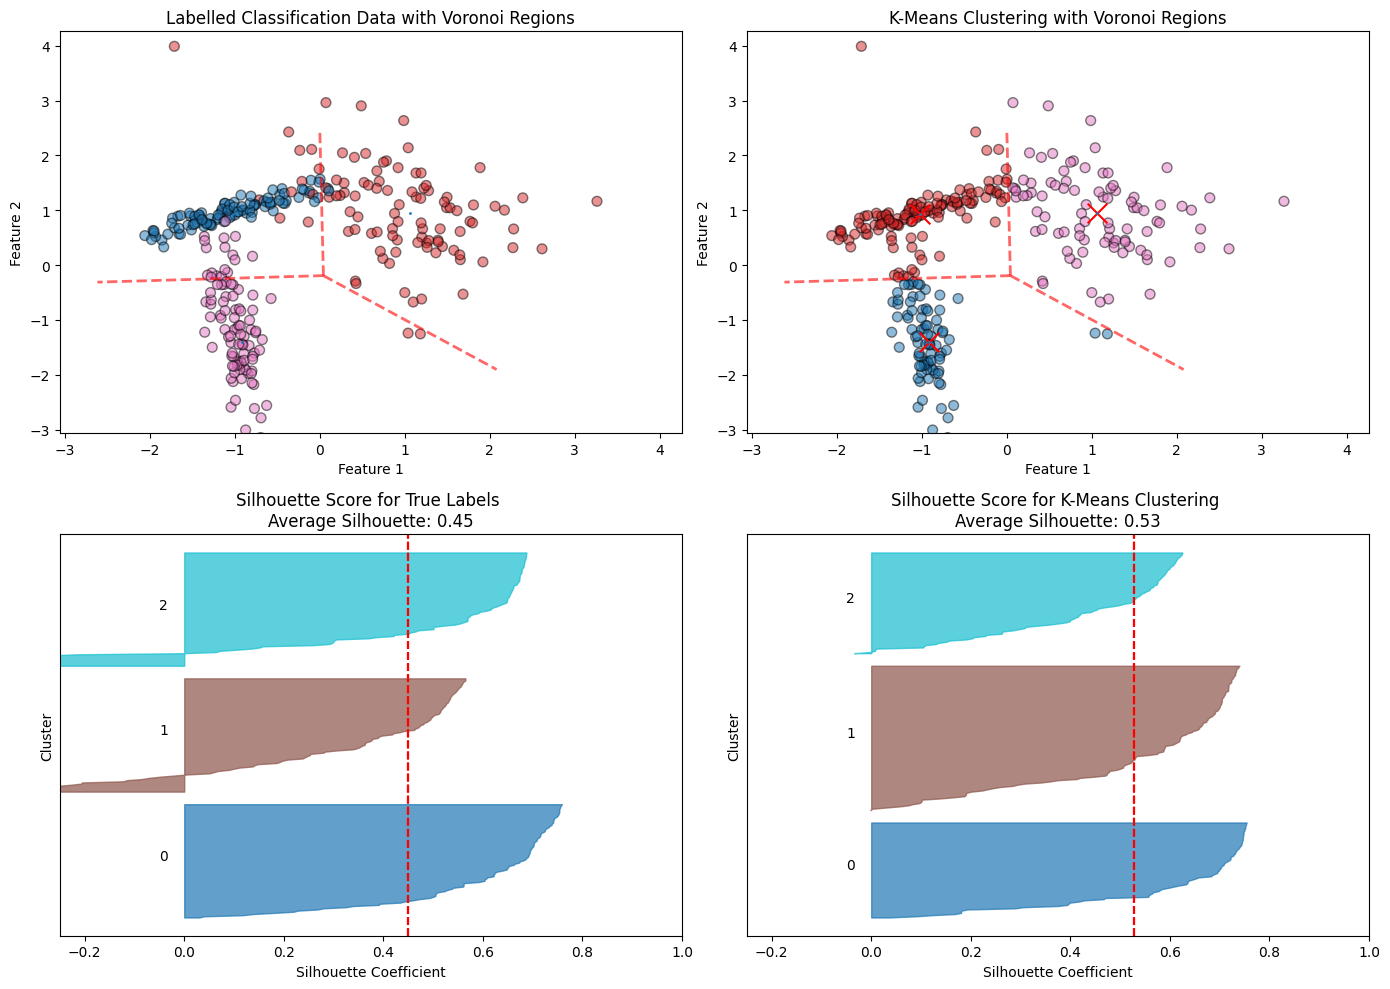

In [12]:
# Generate synthetic classification data
X, y_true = make_classification(n_samples=300, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, n_classes=3, random_state=42)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
y_kmeans = kmeans.fit_predict(X)
centroids = kmeans.cluster_centers_

# Compute the Voronoi diagram
vor = Voronoi(centroids)

# Create a 2x2 grid of subplots
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# Get consistent axis limits for all scatter plots
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 0].min() - 1, X[:, 0].max() + 1

# Plot the true labels with Voronoi regions
colormap = cm.tab10
colors_true = colormap(y_true.astype(float) / 3)
ax[0, 0].scatter(X[:, 0], X[:, 1], c=colors_true, s=50, alpha=0.5, ec="k")
voronoi_plot_2d(vor, ax=ax[0, 0], show_vertices=False, line_colors="red", line_width=2, line_alpha=0.6, point_size=2)
ax[0, 0].set_title('Labelled Classification Data with Voronoi Regions')
ax[0, 0].set_xlabel('Feature 1')
ax[0, 0].set_ylabel('Feature 2')
ax[0, 0].set_xlim(x_min, x_max)
ax[0, 0].set_ylim(y_min, y_max)

# Call evaluate_clustering for true labels
evaluate_clustering(X, y_true, n_clusters=3, ax=ax[1, 0], title_suffix="True Labels")

# Plot K-Means clustering results with Voronoi regions
colors_kmeans = colormap(y_kmeans.astype(float) / 3)
ax[0, 1].scatter(X[:, 0], X[:, 1], c=colors_kmeans, s=50, alpha=0.5, ec="k")
ax[0, 1].scatter(centroids[:, 0], centroids[:, 1], c="red", s=200, marker="x", label="Centroids")
voronoi_plot_2d(vor, ax=ax[0, 1], show_vertices=False, line_colors="red", line_width=2, line_alpha=0.6, point_size=2)
ax[0, 1].set_title('K-Means Clustering with Voronoi Regions')
ax[0, 1].set_xlabel('Feature 1')
ax[0, 1].set_ylabel('Feature 2')
ax[0, 1].set_xlim(x_min, x_max)
ax[0, 1].set_ylim(x_min, x_max)

# Call evaluate_clustering for K-Means labels
evaluate_clustering(X, y_kmeans, n_clusters=3, ax=ax[1, 1], title_suffix="K-Means Clustering")

# Adjust layout and show plot
plt.tight_layout()
plt.show()